In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"

In [ ]:
!pip install pyspark

In [ ]:
# from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

import math
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Read Data

In [ ]:
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.jars.packages', 'org.xerial:sqlite-jdbc:3.34.0')\
        .getOrCreate()

In [ ]:
df = spark.read.format('jdbc') \
        .options(driver='org.sqlite.JDBC', dbtable="Reviews",
                 url='jdbc:sqlite:/content/gdrive/MyDrive/dataset/Reviews.sqlite')\
        .load()

In [ ]:
# dropna() for StringIndexer to avoid NullPointerException
df = df.select("UserId", "ProductId", "Score").dropna()

In [ ]:
df.show(5)

+--------------+----------+-----+
|        UserId| ProductId|Score|
+--------------+----------+-----+
|A3SGXH7AUHU8GW|B001E4KFG0|    5|
|A1D87F6ZCVE5NK|B00813GRG4|    1|
| ABXLMWJIXXAIN|B000LQOCH0|    4|
|A395BORC6FGVXV|B000UA0QIQ|    2|
|A1UQRSCLF8GW1T|B006K2ZZ7K|    5|
+--------------+----------+-----+
only showing top 5 rows



In [ ]:
# ALS requires numeric userId and itemId. Convert to numeric Id
user_indexer = StringIndexer(inputCol="UserId", outputCol="UserIdIdx")
item_indexer = StringIndexer(inputCol="ProductId", outputCol="ProductIdIdx")

indexed = user_indexer.fit(df).transform(df)
indexed = item_indexer.fit(indexed).transform(indexed)

In [ ]:
indexed.show(5)

+--------------+----------+-----+---------+------------+
|        UserId| ProductId|Score|UserIdIdx|ProductIdIdx|
+--------------+----------+-----+---------+------------+
|A3SGXH7AUHU8GW|B001E4KFG0|    5| 209819.0|     53006.0|
|A1D87F6ZCVE5NK|B00813GRG4|    1|  97842.0|     73117.0|
| ABXLMWJIXXAIN|B000LQOCH0|    4|  45611.0|     48562.0|
|A395BORC6FGVXV|B000UA0QIQ|    2|  42473.0|     50325.0|
|A1UQRSCLF8GW1T|B006K2ZZ7K|    5|  55436.0|     24580.0|
+--------------+----------+-----+---------+------------+
only showing top 5 rows



In [ ]:
# Split data into train and test dataset
(train, test) = indexed.select("UserIdIdx", "ProductIdIdx", "Score").randomSplit([0.9, 0.1], seed=0)
train.cache()
test.cache()

DataFrame[UserIdIdx: double, ProductIdIdx: double, Score: int]

### ALS

In [ ]:
# drop cold start strategy to avoid NaN evaluation
als = ALS(maxIter=10, userCol="UserIdIdx", itemCol="ProductIdIdx", ratingCol="Score", coldStartStrategy="drop")

In [ ]:
param_grid = ParamGridBuilder().addGrid(als.regParam, [0.3, 0.4, 0.5]) \
.addGrid(als.rank, [40, 50]).build()

In [ ]:
param_grid

[{Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorization'): 40,
  Param(parent='ALS_d5773dcad842', name='regParam', doc='regularization parameter (>= 0).'): 0.3},
 {Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorization'): 50,
  Param(parent='ALS_d5773dcad842', name='regParam', doc='regularization parameter (>= 0).'): 0.3},
 {Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorization'): 40,
  Param(parent='ALS_d5773dcad842', name='regParam', doc='regularization parameter (>= 0).'): 0.4},
 {Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorization'): 50,
  Param(parent='ALS_d5773dcad842', name='regParam', doc='regularization parameter (>= 0).'): 0.4},
 {Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorization'): 40,
  Param(parent='ALS_d5773dcad842', name='regParam', doc='regularization parameter (>= 0).'): 0.5},
 {Param(parent='ALS_d5773dcad842', name='rank', doc='rank of the factorizat

In [ ]:
evaluator = RegressionEvaluator(metricName="rmse", labelCol="Score",
                               predictionCol="prediction")

In [ ]:
# build cross validation
# cv = CrossValidator(estimator=als, 
#                     estimatorParamMaps=param_grid, 
#                     evaluator=evaluator, 
#                     numFolds=3)

In [ ]:
tvs = TrainValidationSplit(
  estimator=als,
  estimatorParamMaps=param_grid,
  evaluator=evaluator,
  collectSubModels=True
)

In [ ]:
# fit dataset
model = tvs.fit(train)

In [ ]:
# print best model parameters
print(model.bestModel._java_obj.parent().getRegParam())
# print(model.bestModel._java_obj.parent().getMaxIter())
print(model.bestModel._java_obj.parent().getRank())

0.4
50


In [ ]:
# export best model
best_model = model.bestModel
# best_model.save("/content/gdrive/MyDrive/model/ALSModel2")

In [ ]:
model.validationMetrics

[1.8806789694505195,
 1.8791024904470963,
 1.8698867785714366,
 1.8693501714371943,
 1.8897019879193775,
 1.8898777605632413]

In [ ]:
params = [list(item.values()) for item in param_grid]
result = [list(a) for a in zip(model.validationMetrics, params)]

In [ ]:
result

[[1.8806789694505195, [0.3, 40]],
 [1.8791024904470963, [0.3, 50]],
 [1.8698867785714366, [0.4, 40]],
 [1.8693501714371943, [0.4, 50]],
 [1.8897019879193775, [0.5, 40]],
 [1.8898777605632413, [0.5, 50]]]

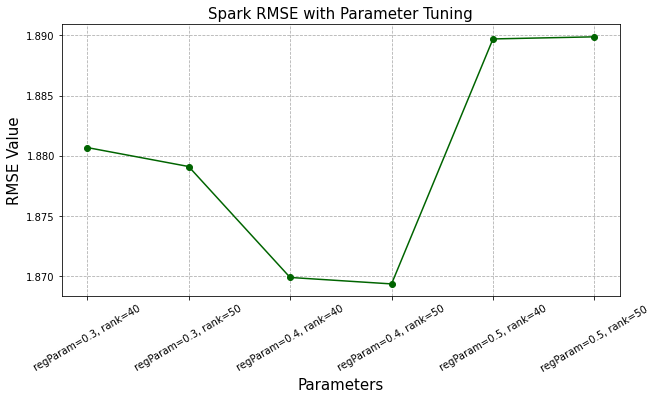

In [ ]:
rmse = [item[0] for item in result]
params = ["regParam="+str(item[1][0])+", rank="+str(item[1][1]) for item in result]
plt.figure(figsize=(10,5))
plt.title('Spark RMSE with Parameter Tuning', loc='center', fontsize=15)
plt.plot(params, rmse, label='RMSE', color='darkgreen', marker='o')
plt.xlabel('Parameters', fontsize=15)
plt.ylabel('RMSE Value', fontsize=15)
plt.xticks(rotation=30)
plt.grid(ls='dashed')

plt.show()

### Evaluate Test Set

In [ ]:
# from pyspark.ml.recommendation import ALS, ALSModel
# ALSModel.load("/content/gdrive/MyDrive/model/ALSModel")

In [ ]:
predictions = best_model.transform(test)
# NA for cold start problem
#predictions = predictions.fillna(0, subset=['prediction'])
rmse = evaluator.evaluate(predictions)
print("RMSE on Test Dataset: " + str(rmse))

RMSE on Test Dataset: 1.6995529112520464


In [ ]:
predictions.tail(5)

[Row(UserIdIdx=22716.0, ProductIdIdx=43822.0, Score=5, prediction=0.4892471432685852),
 Row(UserIdIdx=40098.0, ProductIdIdx=43829.0, Score=1, prediction=1.9918385744094849),
 Row(UserIdIdx=52878.0, ProductIdIdx=43838.0, Score=5, prediction=0.7377405762672424),
 Row(UserIdIdx=12108.0, ProductIdIdx=43839.0, Score=1, prediction=1.0984745025634766),
 Row(UserIdIdx=17402.0, ProductIdIdx=43848.0, Score=5, prediction=4.622934818267822)]